In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import BatchNormalization
from keras.layers import Input, Dense, Conv1D, Conv1DTranspose
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from scipy.interpolate import interp1d

In [ ]:
MITdf = pd.read_csv("/content/gdrive/MyDrive/ECG_Data/mitbih_train.csv", header = None, index_col= False)
raw_data = MITdf.values
MITdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#for row in raw_data:
MITdf_t = MITdf.iloc[:, 0:187]
r_MITdf = MITdf_t.iloc[:, ::-1]
for i in range(0, 87554):
  row = r_MITdf.iloc[i,:]
  row_size = 0
  for j in row:
    if j == 0.0:
      row_size+=1
    else:
      break
  x_ori = np.linspace(0, 186-row_size, 186-row_size+1)
  y_r = row[row_size:187]
  y_ori = y_r[::-1]
  x_new = np.linspace(0, 186-row_size+1, 187)
  #x_new = x_new[0:186]
  f1 = interp1d(x_ori, y_ori, fill_value='extrapolate')
  y_new = []
  for x in x_new:
    y = f1(x)
    y_new.append(y)
  MITdf_t.iloc[i, 0:187] = y_new

MITdf_t.head()

  


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.950269,0.908022,0.776249,0.615697,0.381141,0.224620,0.175864,0.165481,0.185247,0.176418,0.155334,0.122075,0.086496,0.071579,0.058191,0.052920,0.048334,0.045699,0.047807,0.057031,0.062698,0.065333,0.064384,0.061749,0.055872,0.049283,0.061670,0.072871,0.066282,0.061275,0.061275,0.062276,0.064911,0.066862,0.068179,0.078194,0.092689,0.087155,0.076613,...,0.073925,0.203062,0.339316,0.504032,0.657996,0.791087,0.896347,0.971458,0.986111,0.963710,0.871205,0.756562,0.531626,0.300917,0.225806,0.168248,0.190649,0.198714,0.176312,0.149062,0.116118,0.100569,0.096616,0.093638,0.091003,0.095325,0.100437,0.097802,0.095799,0.097117,0.097249,0.094613,0.094297,0.096932,0.097275,0.095957,0.102230,0.111454,0.120678,0.129902
1,0.960114,0.888766,0.673192,0.405983,0.210826,0.126551,0.107159,0.121358,0.102472,0.092547,0.083111,0.074947,0.081243,0.077704,0.070520,0.062816,0.064914,0.065527,0.064792,0.062693,0.073094,0.074258,0.073553,0.081947,0.088411,0.093527,0.094722,0.084229,0.082621,0.085700,0.092547,0.103039,0.115155,0.130365,0.149619,0.174800,0.188218,0.198772,0.213461,0.209540,...,0.024400,0.051466,0.064057,0.102840,0.172257,0.281377,0.453727,0.634899,0.814815,0.978495,0.928913,0.739852,0.458781,0.236345,0.130778,0.080048,0.060993,0.040009,0.015991,0.009190,0.034096,0.021505,0.010278,0.002236,0.000138,0.033330,0.048433,0.049352,0.053549,0.046901,0.046963,0.054744,0.058941,0.061483,0.065389,0.071531,0.075728,0.088932,0.105719,0.122507
2,1.000000,0.826068,0.649288,0.407716,0.181488,0.122130,0.070270,0.070270,0.069340,0.063819,0.059169,0.057788,0.055013,0.048111,0.044871,0.050392,0.052659,0.048518,0.048038,0.053560,0.053851,0.046949,0.048997,0.061421,0.066173,0.063412,0.066696,0.074978,0.076751,0.073990,0.077332,0.084234,0.084627,0.081866,0.090962,0.104766,0.109154,0.110535,0.120750,0.133173,...,0.007585,0.021389,0.031052,0.024150,0.019253,0.020634,0.024368,0.034031,0.073874,0.176024,0.306146,0.484220,0.667960,0.859837,0.876765,0.682127,0.467001,0.230950,0.088274,0.026155,0.010389,0.028335,0.035135,0.035135,0.032389,0.028248,0.025080,0.022319,0.024717,0.028858,0.022101,0.012438,0.019994,0.031037,0.027608,0.022087,0.035527,0.050712,0.065897,0.081081
3,0.925414,0.791392,0.661736,0.597576,0.524327,0.387453,0.268490,0.227143,0.180806,0.119497,0.076457,0.073605,0.069685,0.063981,0.062021,0.064873,0.064160,0.059882,0.059615,0.062467,0.069774,0.079754,0.083853,0.085279,0.088843,0.093121,0.102032,0.112012,0.118250,0.123953,0.132329,0.140884,0.136607,0.132864,0.137141,0.137676,0.112012,0.090626,0.087774,0.084210,...,0.140528,0.151577,0.165835,0.261183,0.375245,0.559169,0.753074,0.878809,1.000000,0.924434,0.847621,0.752094,0.654963,0.546605,0.445197,0.373908,0.304046,0.238460,0.181786,0.144716,0.113527,0.092140,0.080734,0.082160,0.080021,0.074318,0.067813,0.060684,0.060684,0.064962,0.074140,0.085546,0.091606,0.095883,0.097844,0.099269,0.104438,0.110141,0.115844,0.121547
4,0.967136,0.991872,0.914584,0.767984,0.584381,0.411227,0.301075,0.221061,0.144328,0.101923,0.104044,0.126559,0.149629,0.135494,0.126407,0.127518,0.141653,0.155788,0.154475,0.148821,0.145035,0.137968,0.154526,0.171942,0.178101,0.174567,0.179060,0.189156,0.200818,0.190217,0.174163,0.172144,0.190217,0.211419,0.215962,0.211116,0.202787,0.209854,0.222576,0.225049,...,0.067394,0.080670,0.123075,0.222020,0.407189,0.599324,0.768439,0.870917,0.929577,0.933364,0.867333,0.697713,0.512191,0.353173,0.229946,0.152204,0.087385,0.063103,0.072997,0.101267,0.103286,0.094805,0.086425,0.093493,0.110556,0.119542,0.119037,0.108436,0.111364,0.128225,0.147660,0.154728,0.127467,0.128729,0.146398,0.164067,0.167803,0.166692,0.163158,0.159624


In [ ]:
MITdf_t.to_pickle("/content/gdrive/MyDrive/ECG_Data/interpolation.pkl")

In [ ]:
MITdf_t = pd.read_pickle("/content/gdrive/MyDrive/ECG_Data/interpolation.pkl")
labels = raw_data[:,-1]
anomal_labels = np.where(labels == 2.0, 1.0, labels)
anomal_labels = np.where(labels == 3.0, 1.0, labels)
anomal_labels = np.where(labels == 4.0, 1.0, labels)
print(anomal_labels)
data = MITdf_t.values

train_data, test_data, train_labels, test_labels = train_test_split(
    data, anomal_labels, test_size = 0.2, random_state = 21
)


[0. 0. 0. ... 1. 1. 1.]


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

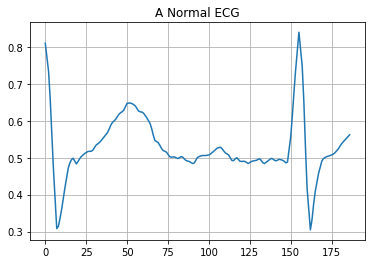

In [ ]:
plt.grid()
plt.plot(np.arange(187), normal_train_data[0])
# plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()
# for i in range(15):
#   plt.plot(np.arange(140), normal_train_data[i])
#   plt.title("A Normal ECG")
#   plt.show()

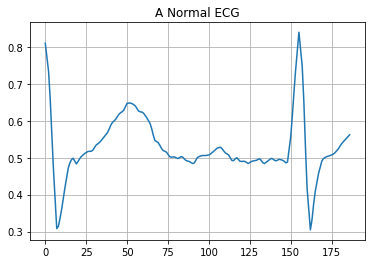

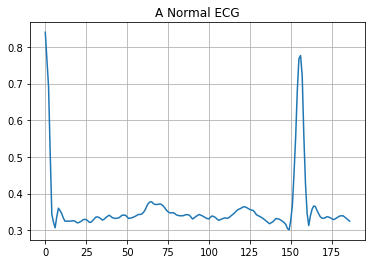

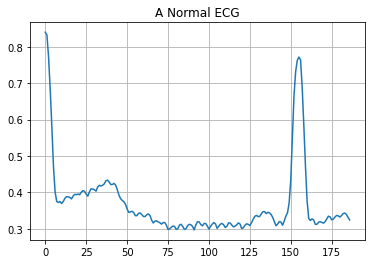

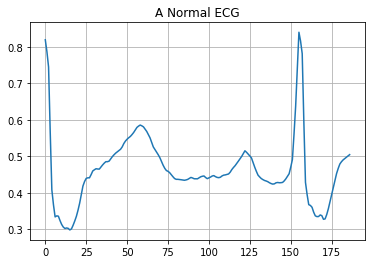

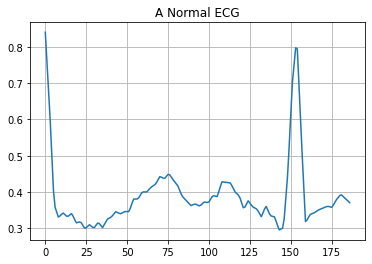

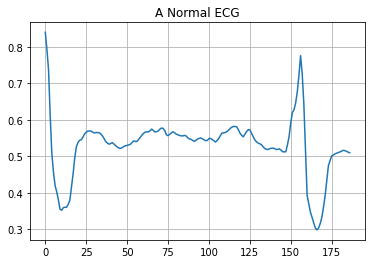

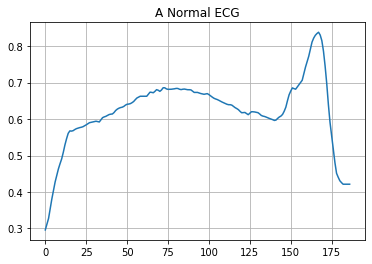

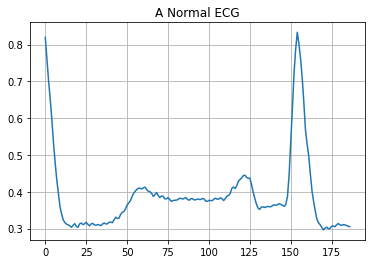

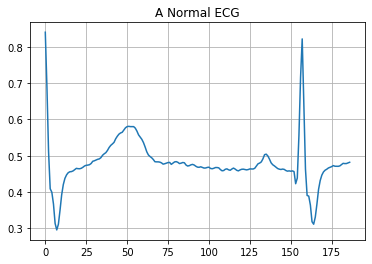

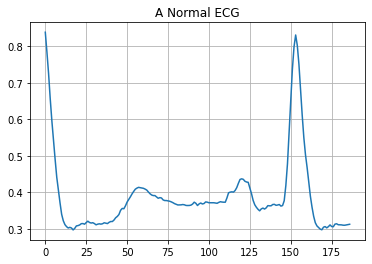

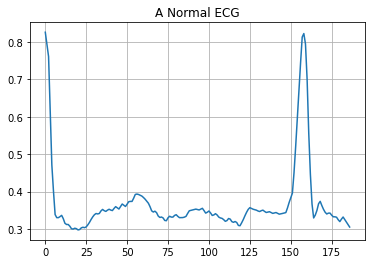

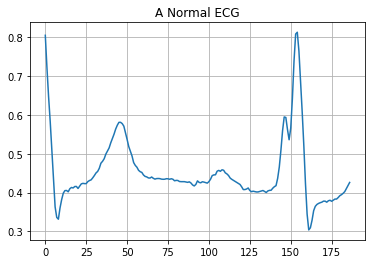

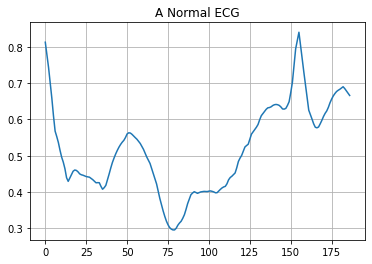

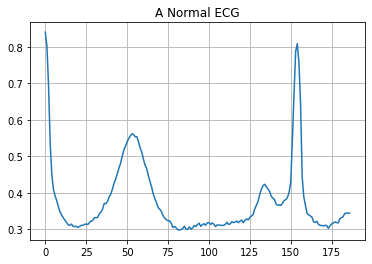

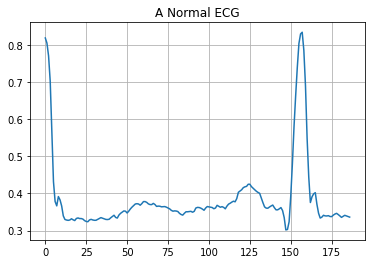

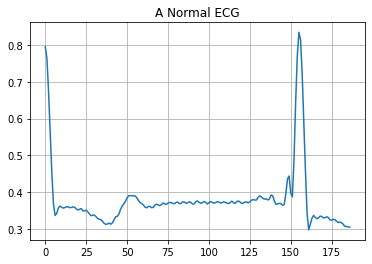

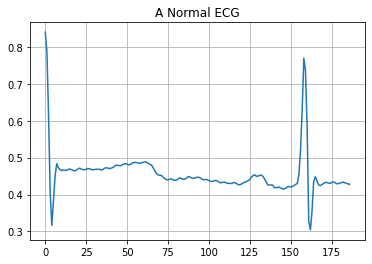

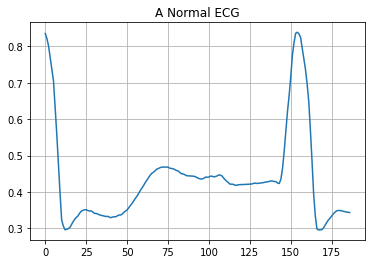

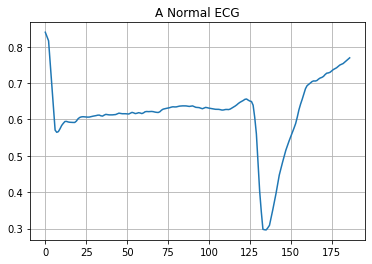

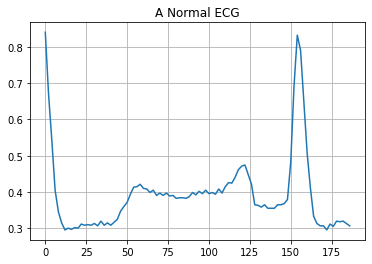

In [ ]:
for i in range(20):
  plt.grid()
  plt.plot(np.arange(187), normal_train_data[i])
  plt.title("A Normal ECG")
  plt.show()

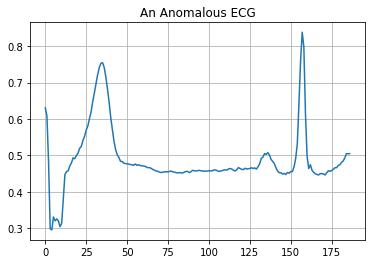

In [ ]:
plt.grid()
plt.plot(np.arange(187), anomalous_train_data[0])
# plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

CONVOLUTION_AUTOENCODER

In [ ]:
class AnomalyDetector_Conv(Model):
  def __init__(self):
    super(AnomalyDetector_Conv, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(187, 1)),
      Conv1D(filters=64, kernel_size=4, padding='same', strides=2, activation="relu"),
      Conv1D(filters=32, kernel_size=4, padding='same', strides=2, activation="relu"),
      Conv1D(filters=16, kernel_size=4, padding='same', strides=2, activation="relu"),
      Conv1D(filters=8, kernel_size=4, padding='same', strides=2, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Conv1DTranspose(filters=8, kernel_size=4, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=16, kernel_size=4, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=32, kernel_size=4, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=64, kernel_size=4, padding='same', strides=2, activation="relu"),
      Conv1D(filters=64, kernel_size=6, strides=1, activation="relu"),
      Conv1DTranspose(filters=1, kernel_size=7, padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv = AnomalyDetector_Conv()

In [ ]:
autoencoder_conv.compile(optimizer='adam', loss='mae')

In [ ]:
history_conv = autoencoder_conv.fit(normal_train_data, normal_train_data, 
                                    epochs=10, 
                                    batch_size=512,
                                    validation_data=(test_data, test_data),
                                    shuffle=True)

Epoch 1/10
114/114 [==============================] - 75s 650ms/step - loss: 0.1023 - val_loss: 0.0345
Epoch 2/10
114/114 [==============================] - 71s 624ms/step - loss: 0.0277 - val_loss: 0.0213
Epoch 3/10
114/114 [==============================] - 71s 624ms/step - loss: 0.0176 - val_loss: 0.0154
Epoch 4/10
114/114 [==============================] - 71s 622ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 5/10
114/114 [==============================] - 70s 616ms/step - loss: 0.0118 - val_loss: 0.0123
Epoch 6/10
114/114 [==============================] - 70s 615ms/step - loss: 0.0101 - val_loss: 0.0108
Epoch 7/10
114/114 [==============================] - 70s 616ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 8/10
114/114 [==============================] - 70s 617ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 9/10
114/114 [==============================] - 71s 620ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 10/10
114/114 [==============================] - 70s 616ms/step - l

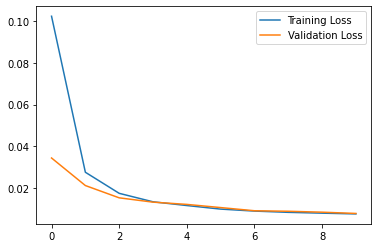

In [ ]:
plt.plot(history_conv.history["loss"], label="Training Loss")
plt.plot(history_conv.history["val_loss"], label="Validation Loss")
plt.legend()

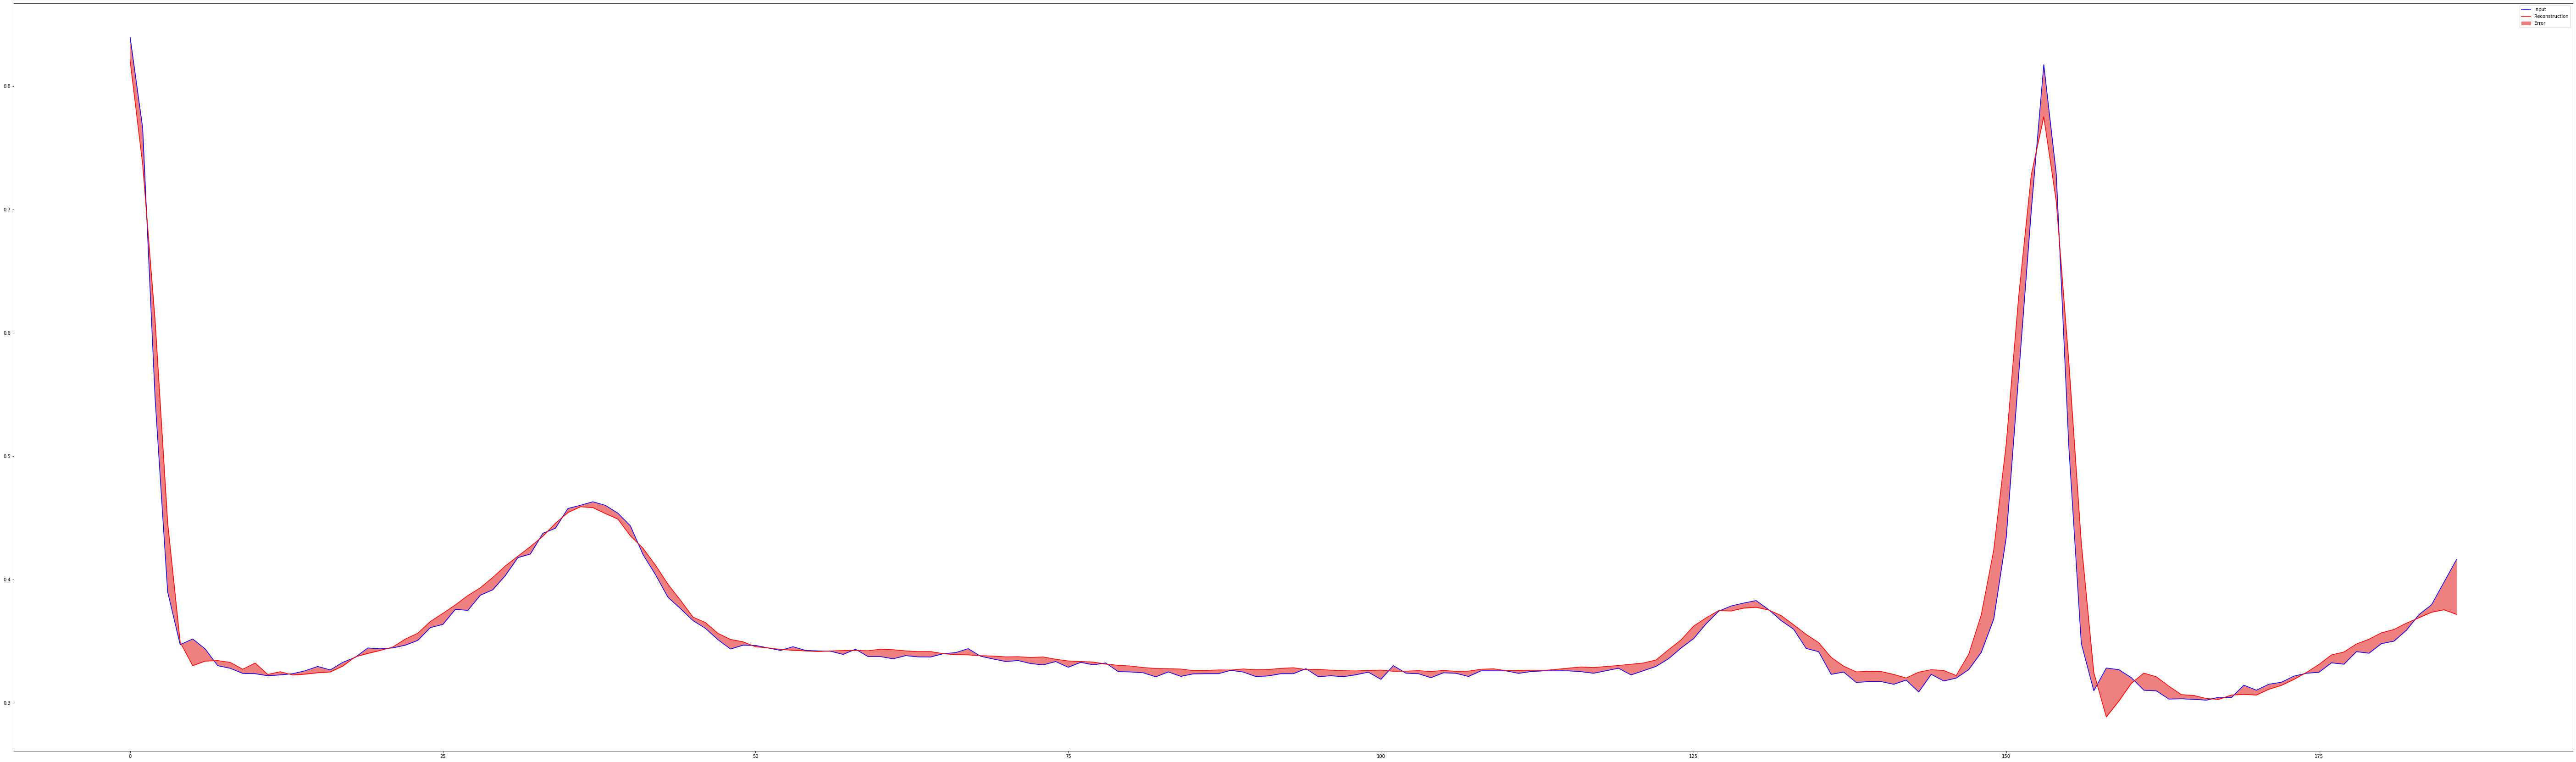

In [ ]:
encoded_imgs = autoencoder_conv.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder_conv.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)
plt.figure(figsize=(100,30))
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

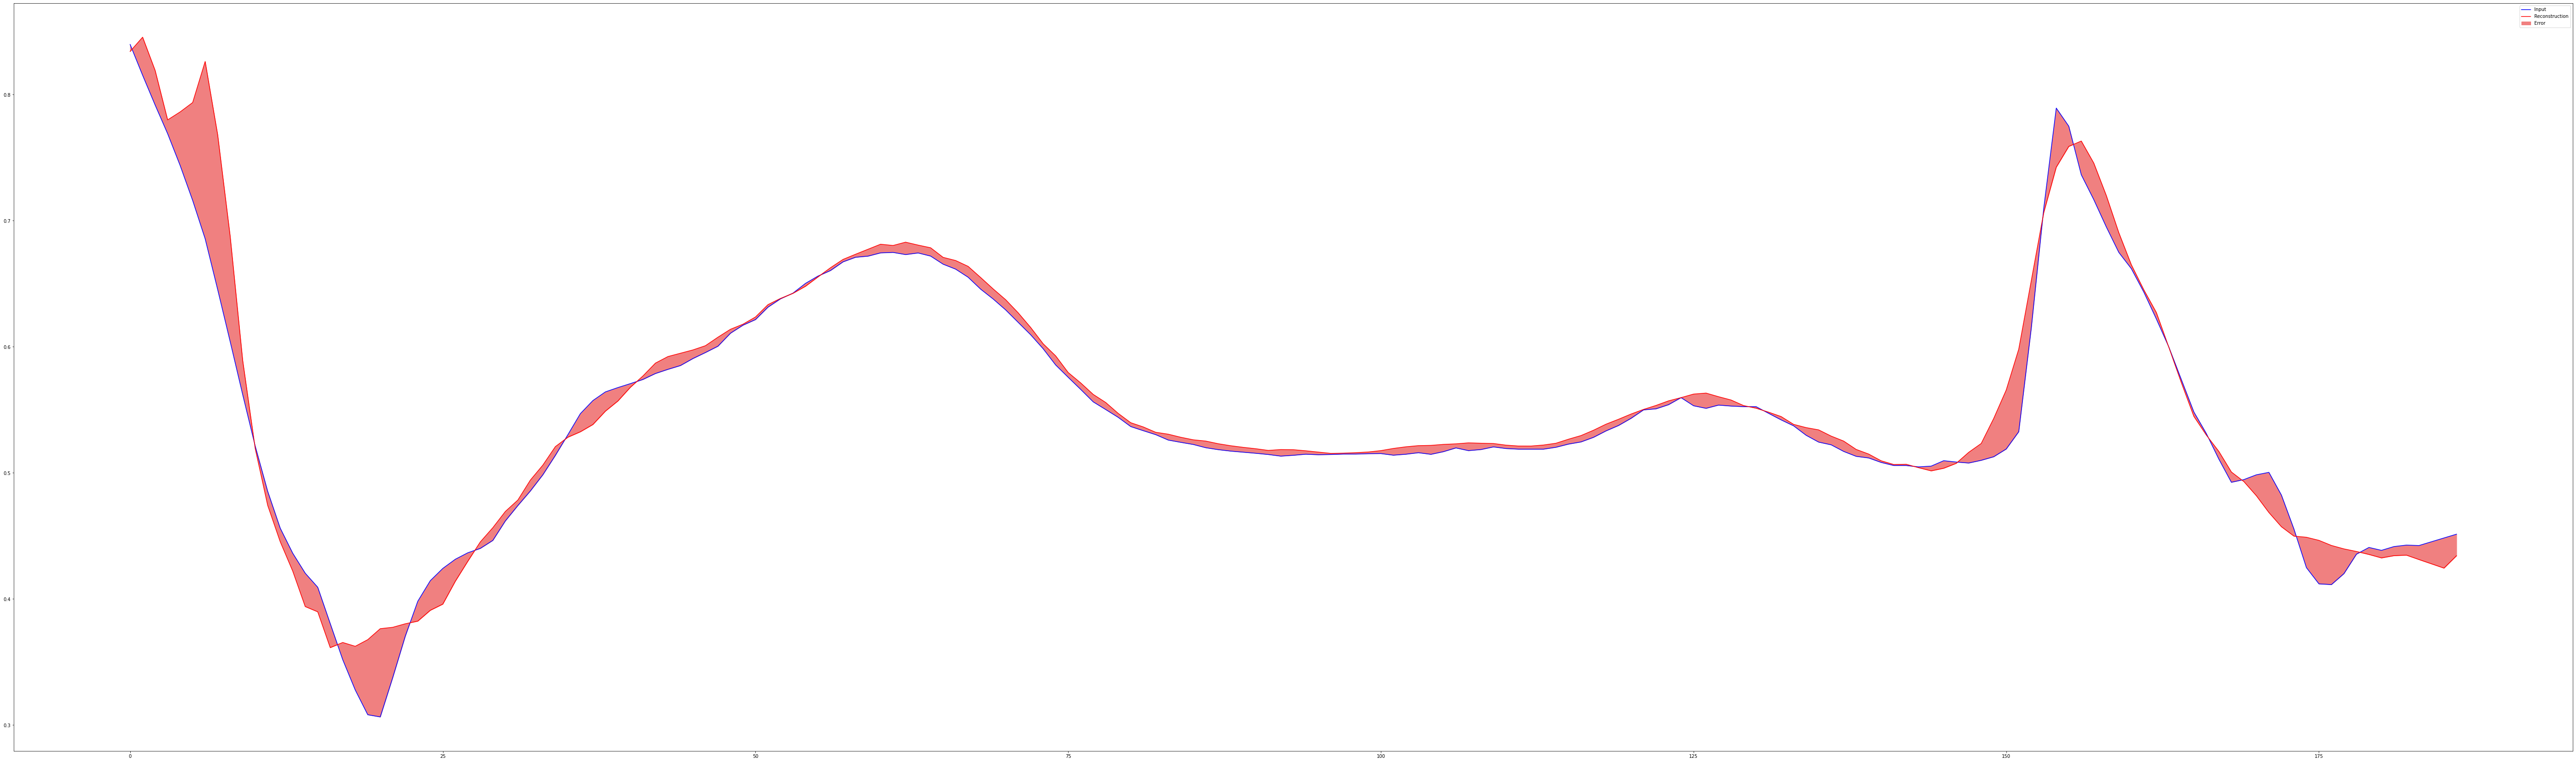

In [ ]:
encoded_imgs = autoencoder_conv.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder_conv.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)
plt.figure(figsize=(100,30))
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

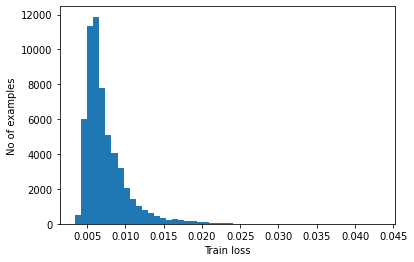

In [ ]:
reconstructions_conv = autoencoder_conv.predict(normal_train_data)
reconstructions_conv = np.squeeze(reconstructions_conv)
train_loss = tf.keras.losses.mae(reconstructions_conv, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.010173311


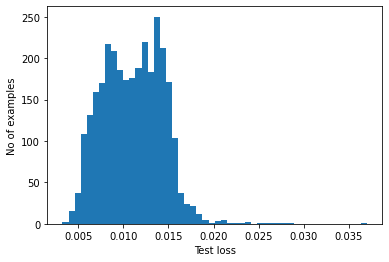

In [ ]:
reconstructions_conv = autoencoder_conv.predict(anomalous_test_data)
reconstructions_conv = np.squeeze(reconstructions_conv)
test_loss = tf.keras.losses.mae(reconstructions_conv, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict_conv(model, data, threshold):
  reconstructions = model(data)
  reconstructions = np.squeeze(reconstructions)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
pred_conv = predict_conv(autoencoder_conv, test_data, threshold)
print_stats(pred_conv, ~test_labels)

Accuracy = 0.830677859631089
Precision = 0.9091296625222025
Recall = 0.8835796160751277


VANILLA AUTOENCODER

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      Dense(32, activation="relu"),
      Dense(16, activation="relu"),
      Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Dense(16, activation="relu"),
      Dense(32, activation="relu"),
      Dense(187, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
114/114 [==============================] - 2s 9ms/step - loss: 0.0783 - val_loss: 0.0550
Epoch 2/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0445 - val_loss: 0.0448
Epoch 3/20
114/114 [==============================] - 1s 7ms/step - loss: 0.0376 - val_loss: 0.0384
Epoch 4/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0333 - val_loss: 0.0367
Epoch 5/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0316 - val_loss: 0.0349
Epoch 6/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0306 - val_loss: 0.0336
Epoch 7/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0296 - val_loss: 0.0329
Epoch 8/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0288 - val_loss: 0.0317
Epoch 9/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0319
Epoch 10/20
114/114 [==============================] - 1s 6ms/step - loss: 0.0278 - val_loss: 0.0308

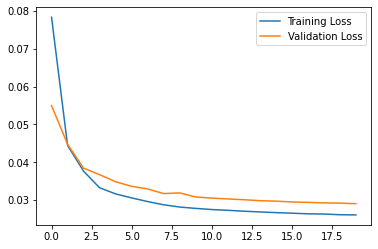

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

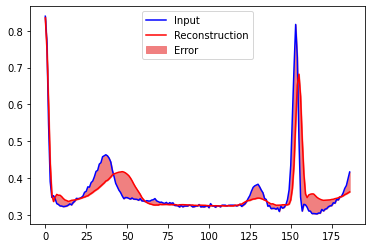

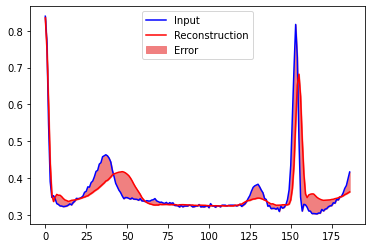

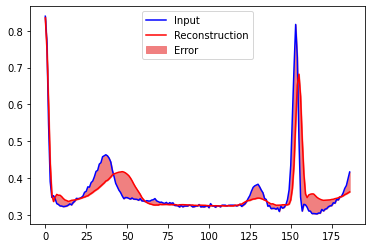

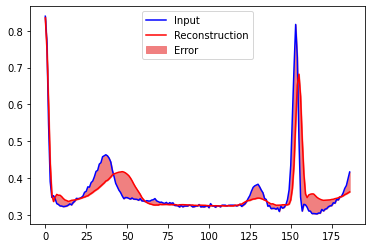

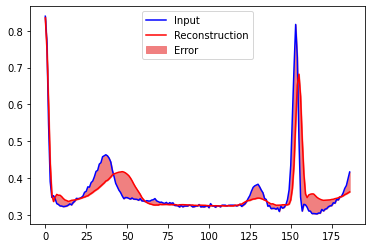

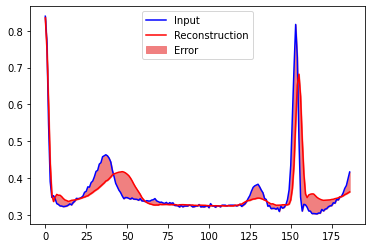

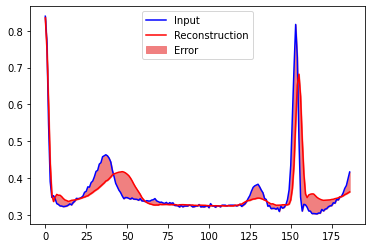

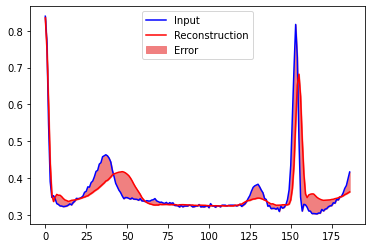

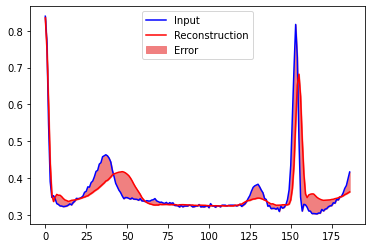

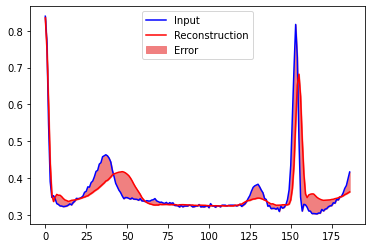

In [ ]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# plt.plot(normal_test_data[0], 'b')
# plt.plot(decoded_imgs[0], 'r')
# plt.fill_between(np.arange(187), decoded_imgs[0], normal_test_data[0], color='lightcoral')
# plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show()

for i in range (10):
  plt.plot(normal_test_data[0], 'b')
  plt.plot(decoded_imgs[0], 'r')
  plt.fill_between(np.arange(187), decoded_imgs[0], normal_test_data[0], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

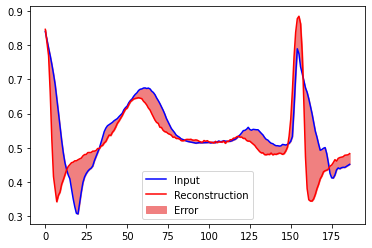

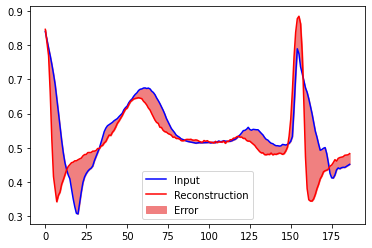

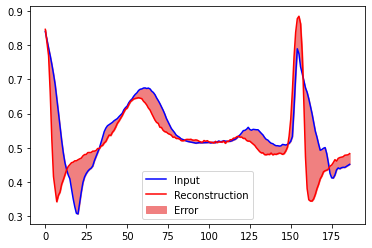

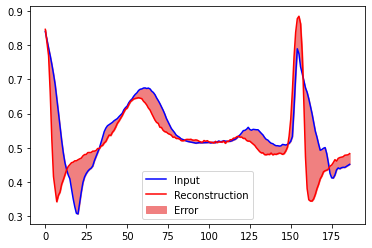

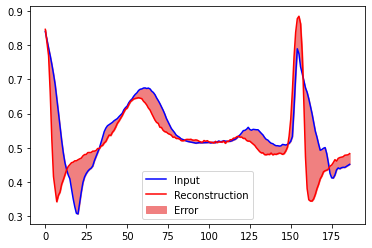

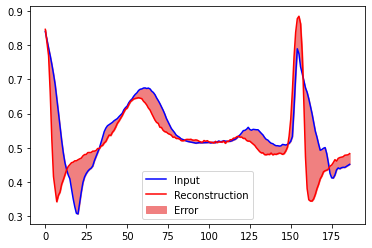

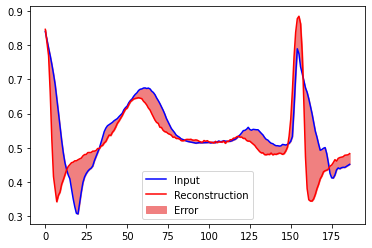

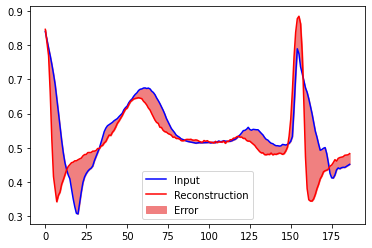

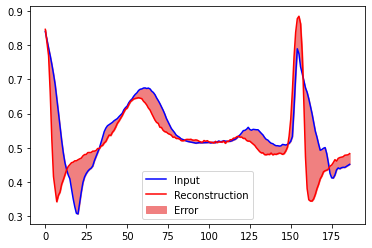

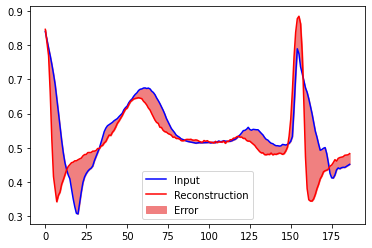

In [ ]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# plt.plot(anomalous_test_data[0], 'b')
# plt.plot(decoded_imgs[0], 'r')
# plt.fill_between(np.arange(187), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
# plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show()

for i in range (10):
  plt.plot(anomalous_test_data[0], 'b')
  plt.plot(decoded_imgs[0], 'r')
  plt.fill_between(np.arange(187), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

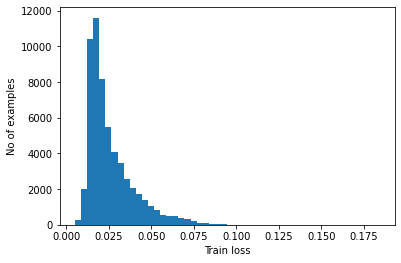

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03981003


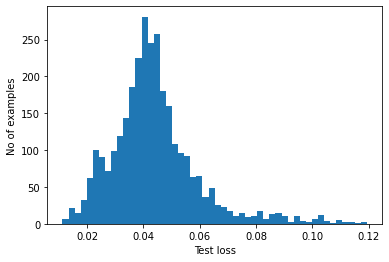

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, ~test_labels)

Accuracy = 0.80840614470904
Precision = 0.9088704343352686
Recall = 0.8539566358237812


In [ ]:
def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr)
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

plot_roc_curve(fpr, tpr)

NameError: ignored

In [ ]:
class AnomalyDetector_Conv_v2(Model):
  def __init__(self):
    super(AnomalyDetector_Conv_v2, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(187, 1)),
      Conv1D(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1D(filters=16, kernel_size=7, padding='same', strides=2, activation="relu")])

    self.decoder = tf.keras.Sequential([
      Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=2, activation="relu"),
      Conv1DTranspose(filters=1, kernel_size=7, padding='same'),
      Conv1D(filters=1, kernel_size=2, strides=1, activation="relu")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv_v2 = AnomalyDetector_Conv_v2()

In [ ]:
autoencoder_conv_v2.compile(optimizer='adam', loss='mae')

In [ ]:
history_conv_v2 = autoencoder_conv_v2.fit(normal_train_data, normal_train_data, 
                                          epochs=10, 
                                          batch_size=512,
                                          validation_data=(test_data, test_data),
                                          shuffle=True)

Epoch 1/10
114/114 [==============================] - 22s 186ms/step - loss: 0.2592 - val_loss: 0.2371
Epoch 2/10
114/114 [==============================] - 21s 185ms/step - loss: 0.2255 - val_loss: 0.2284
Epoch 3/10
114/114 [==============================] - 21s 184ms/step - loss: 0.2230 - val_loss: 0.2277
Epoch 4/10
114/114 [==============================] - 21s 183ms/step - loss: 0.2224 - val_loss: 0.2272
Epoch 5/10
114/114 [==============================] - 21s 183ms/step - loss: 0.2221 - val_loss: 0.2270
Epoch 6/10
114/114 [==============================] - 21s 184ms/step - loss: 0.2219 - val_loss: 0.2267
Epoch 7/10
114/114 [==============================] - 21s 183ms/step - loss: 0.2217 - val_loss: 0.2265
Epoch 8/10
114/114 [==============================] - 21s 183ms/step - loss: 0.2216 - val_loss: 0.2266
Epoch 9/10
114/114 [==============================] - 21s 184ms/step - loss: 0.2215 - val_loss: 0.2263
Epoch 10/10
114/114 [==============================] - 21s 183ms/step - l

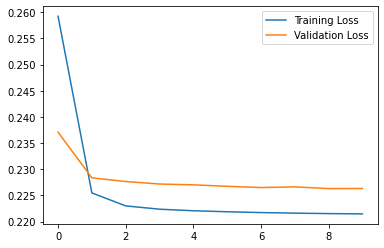

In [ ]:
plt.plot(history_conv_v2.history["loss"], label="Training Loss")
plt.plot(history_conv_v2.history["val_loss"], label="Validation Loss")
plt.legend()

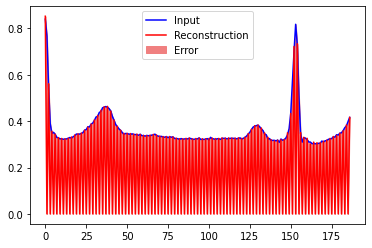

In [ ]:
encoded_imgs = autoencoder_conv_v2.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder_conv_v2.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

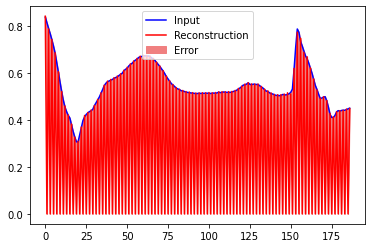

In [ ]:
encoded_imgs = autoencoder_conv_v2.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder_conv_v2.decoder(encoded_imgs).numpy()
decoded_imgs = np.squeeze(decoded_imgs)

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(187), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

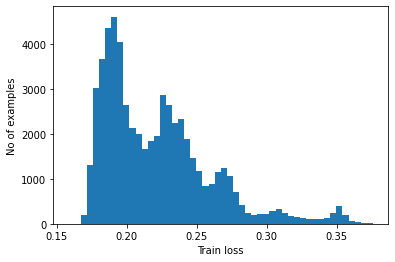

In [ ]:
reconstructions_conv_v2 = autoencoder_conv_v2.predict(normal_train_data)
reconstructions_conv_v2 = np.squeeze(reconstructions_conv_v2)
train_loss = tf.keras.losses.mae(reconstructions_conv_v2, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.2597294


In [ ]:
def predict_conv(model, data, threshold):
  reconstructions = model(data)
  reconstructions = np.squeeze(reconstructions)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

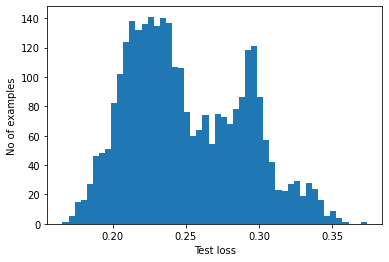

In [ ]:
reconstructions_conv_v2 = autoencoder_conv_v2.predict(anomalous_test_data)
reconstructions_conv_v2 = np.squeeze(reconstructions_conv_v2)
test_loss = tf.keras.losses.mae(reconstructions_conv_v2, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
pred_conv_v2 = predict_conv(autoencoder_conv_v2, test_data, threshold)
print_stats(pred_conv_v2, ~test_labels)

Accuracy = 0.7695163040374622
Precision = 0.8683876428269149
Recall = 0.8501588178428394
